---

##  2.3 策略迭代法的实现

- `策略迭代法`：

   在根据策略行动最终到达目标时，那种更快到达目标的策略下所执行的动作（action）是更重要的，可以对策略进行更新，以后更多地采用这一行动。换句话说，这是一项强调成功案例动作的行动方案.
- `价值迭代法`：

   从目标反向计算在目标的前一步、前两步的位置（状态）等，一步步引导智能体的行为。换句话说，它是一种给目标以外的位置（状态）也附加价值（优先级）的行动方案。

### 2.3.1 `策略迭代法`与`价值迭代法`

`策略梯度法`（policy gradient method）是`策略迭代法`的一种具体算法。

`softmax函数`是机器学习、深度学习中经常使用的函数：

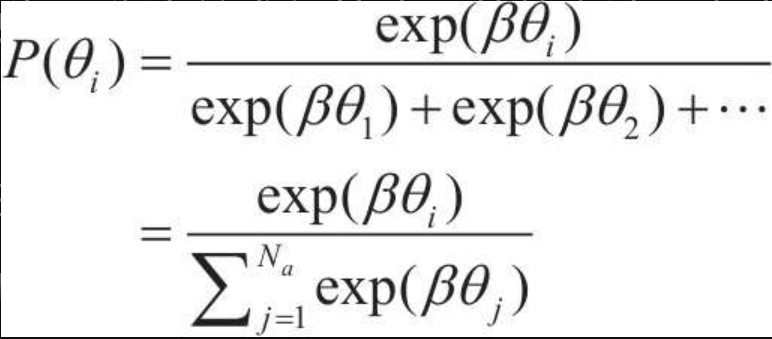

其中`Na`表示可以选择的动作类型的总数。

---

### 2.3.2 根据`策略梯度法`移动智能体

In [40]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

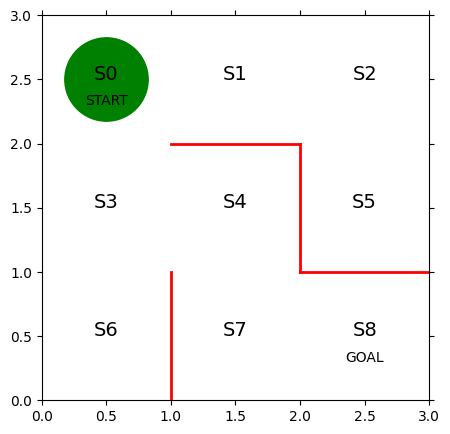

In [41]:
# 声明图的大小及图的变量名
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 画出红色的墙壁
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 画出表示状态的文字 S0~S8
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 设定画图的范围
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 当前位置S0用绿色圆圈画出
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

In [42]:
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8是目标
                    ])

前三个代码片段与之前相同。

以下计算比率的代码片段从简单计算比率改成利用exp的softmax函数。

In [43]:
def softmax_convert_into_pi_from_theta(theta):
    '''根据softmax函数计算比率'''

    beta = 1.0
    [m, n] = theta.shape  # 求得theta的矩阵大小
    pi = np.zeros((m, n))

    exp_theta = np.exp(beta * theta)  # 将theta转换为exp(theta)，即求指数
    for i in range(0, m):
        # pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
        # 简单地计算比率

        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
        # 用softmax计算比率

    pi = np.nan_to_num(pi)  # nan转换为0

    return pi

In [44]:
# 求得初始策略pi_0
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

In [45]:
# 定义求取动作a以及1步移动后的状态s的函数

def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    # 根据概率pi[s,:]选择direction
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - 3  # 向上移动时状态的数字减少3
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 向右移动时状态的数字增加1
    elif next_direction == "down":
        action = 2
        s_next = s + 3  # 向下移动时状态的数字增加3
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 向左移动时状态的数字减少1

    return [action, s_next]

In [46]:
# 定义求解迷宫问题的函数，它输出状态和动作


def goal_maze_ret_s_a(pi):
    s = 0  # 开始地点
    s_a_history = [[0, np.nan]]  # 记录智能体移动的列表

    while (1):  # 直至达到目标的路径
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action
        # 代入当前状态(即目前最后一个状态idnex=-1)的动作

        s_a_history.append([next_s, np.nan])
        # 代入下一个状态，由于还不知道其动作，用nan表示

        if next_s == 8:  # 达到目标地点则终止
            break
        else:
            s = next_s

    return s_a_history

In [47]:
# 在迷宫内朝目标移动
s_a_history = goal_maze_ret_s_a(pi_0)

print(s_a_history)
print("求解迷宫路径所需的步骤是 " + str(len(s_a_history) - 1))

[[0, 1], [1, 1], [2, 2], [5, 0], [2, 3], [1, 1], [2, 3], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 1], [4, 3], [3, 2], [6, 0], [3, 2], [6, 0], [3, 2], [6, 0], [3, 0], [0, 2], [3, 0], [0, 2], [3, 0], [0, 2], [3, 2], [6, 0], [3, 1], [4, 2], [7, 0], [4, 2], [7, 1], [8, nan]]
求解迷宫路径所需的步骤是 40


---

### 2.3.3 根据`策略梯度法`更新策略

策略梯度法中，参数theta根据以下公式更新

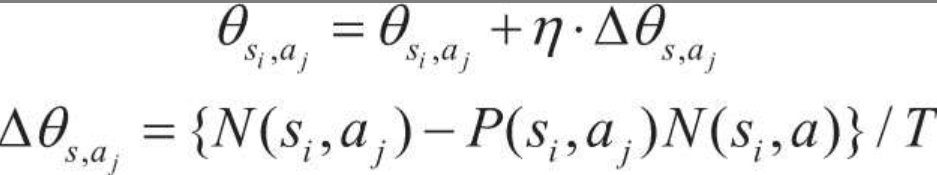

In [48]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 学习率
    T = len(s_a_history) - 1  # 到达目标的总步数

    [m, n] = theta.shape  # theta矩阵的大小
    delta_theta = theta.copy()  # 生成初始的delta_theta，由于指针原因不能直接使用delta_theta=theta

    # 求取delta_theta的各元素
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])):  # theta不是nan时

                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 从列表中取出状态i

                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                # 取出状态i下应该采取的动作j

                N_i = len(SA_i)  # 状态i下动作的总次数
                N_ij = len(SA_ij)  # 状态i下采取动作j的次数
                
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T

    new_theta = theta + eta * delta_theta

    return new_theta

In [50]:
# 策略更新
new_theta = update_theta(theta_0, pi_0, s_a_history)
print(new_theta)

pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[    nan 0.9975  1.0025      nan]
 [    nan 1.0025      nan 0.9975 ]
 [    nan     nan 0.99875 1.00125]
 [1.      0.9975  1.0025      nan]
 [    nan     nan 1.00125 0.99875]
 [1.          nan     nan     nan]
 [1.          nan     nan     nan]
 [1.      1.          nan     nan]]
[[0.         0.49875    0.50125    0.        ]
 [0.         0.50125    0.         0.49875   ]
 [0.         0.         0.499375   0.500625  ]
 [0.33333264 0.33250035 0.33416701 0.        ]
 [0.         0.         0.500625   0.499375  ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [54]:
# 策略梯度法求解迷宫问题

stop_epsilon = 10**-4  # 策略的变化小于10^-4则结束学习


theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:  # 重复执行，知道is_continue为False
    s_a_history = goal_maze_ret_s_a(pi)  # 由策略pi搜索迷宫探索历史
    new_theta = update_theta(theta, pi, s_a_history)  # 更新参数theta
    new_pi = softmax_convert_into_pi_from_theta(new_theta)  # 更新参数pi

    print(np.sum(np.abs(new_pi - pi)))  # 输出策略的变化
    print("求解迷宫问题所需的步数 " + str(len(s_a_history) - 1))

    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi

0.020375403614788623
求解迷宫问题所需的步数 12
0.048496578095411025
求解迷宫问题所需的步数 4
0.048011297879953896
求解迷宫问题所需的步数 4
0.0255233886931579
求解迷宫问题所需的步数 12
0.024405901350925796
求解迷宫问题所需的步数 8
0.009489685635045653
求解迷宫问题所需的步数 38
0.031219945316842912
求解迷宫问题所需的步数 6
0.012288514240200277
求解迷宫问题所需的步数 36
0.019698649611940233
求解迷宫问题所需的步数 10
0.024708566348640493
求解迷宫问题所需的步数 8
0.024596635680330492
求解迷宫问题所需的步数 8
0.00850701911004681
求解迷宫问题所需的步数 42
0.029545453795553234
求解迷宫问题所需的步数 16
0.015009158040020565
求解迷宫问题所需的步数 66
0.02338131436917934
求解迷宫问题所需的步数 8
0.02260074914576432
求解迷宫问题所需的步数 12
0.020593881080944343
求解迷宫问题所需的步数 8
0.010688362787097838
求解迷宫问题所需的步数 50
0.01340319321429595
求解迷宫问题所需的步数 22
0.04552349786686022
求解迷宫问题所需的步数 4
0.006890566923758612
求解迷宫问题所需的步数 30
0.009229294085880024
求解迷宫问题所需的步数 70
0.019562711465611005
求解迷宫问题所需的步数 18
0.013796859393256755
求解迷宫问题所需的步数 20
0.009119525182271992
求解迷宫问题所需的步数 74
0.032564737607701455
求解迷宫问题所需的步数 6
0.00959342462382129
求解迷宫问题所需的步数 28
0.009168852791088533
求解迷宫问题所需的步数 82
0.04474451

In [55]:
# 确认最终的策略
np.set_printoptions(precision=3, suppress=True) # 设置为有效位数为3, 不显示指数
print(pi)

[[0.    0.01  0.99  0.   ]
 [0.    0.298 0.    0.702]
 [0.    0.    0.448 0.552]
 [0.011 0.978 0.011 0.   ]
 [0.    0.    0.986 0.014]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.019 0.981 0.    0.   ]]


In [56]:
# 将智能体移动的情形可视化

from matplotlib import animation
from IPython.display import HTML


def init():
    # 初始化背景图像
    line.set_data([], [])
    return (line,)


def animate(i):
    # 每一帧画面的内容
    state = s_a_history[i][0]  # 画出现在的场景
    x = (state % 3) + 0.5  # 状态的x坐标为状态除以3的余数加0.5
    y = 2.5 - int(state / 3)  # 状态的y坐标为2.5减去(状态数除以3)
    line.set_data(x, y)
    return (line,)


#　生成动画
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())

C:\Users\Yulu Xu\AppData\Local\Temp\ipykernel_8428\3278963034.py:18: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)
